In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import pandas as pd
from dataset_soilmoisture import get_dataloader

In [6]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

In [10]:
dataset = 'soilmoisture'
datafolder = 'soilmoisture_longformer'

nsample = 10  # number of generated samples

path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk'

if torch.cuda.is_available():
    with open(path, 'rb') as f:
        samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load(f)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [16]:
all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

all_target_np=(all_target_np*scaler+mean_scaler)
samples=(samples*scaler+mean_scaler)

In [17]:
qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)
    #quantiles_imp.append(get_quantile(samples, q, dim=1))

In [18]:
quantiles_imp[0].shape

(216, 108, 36)

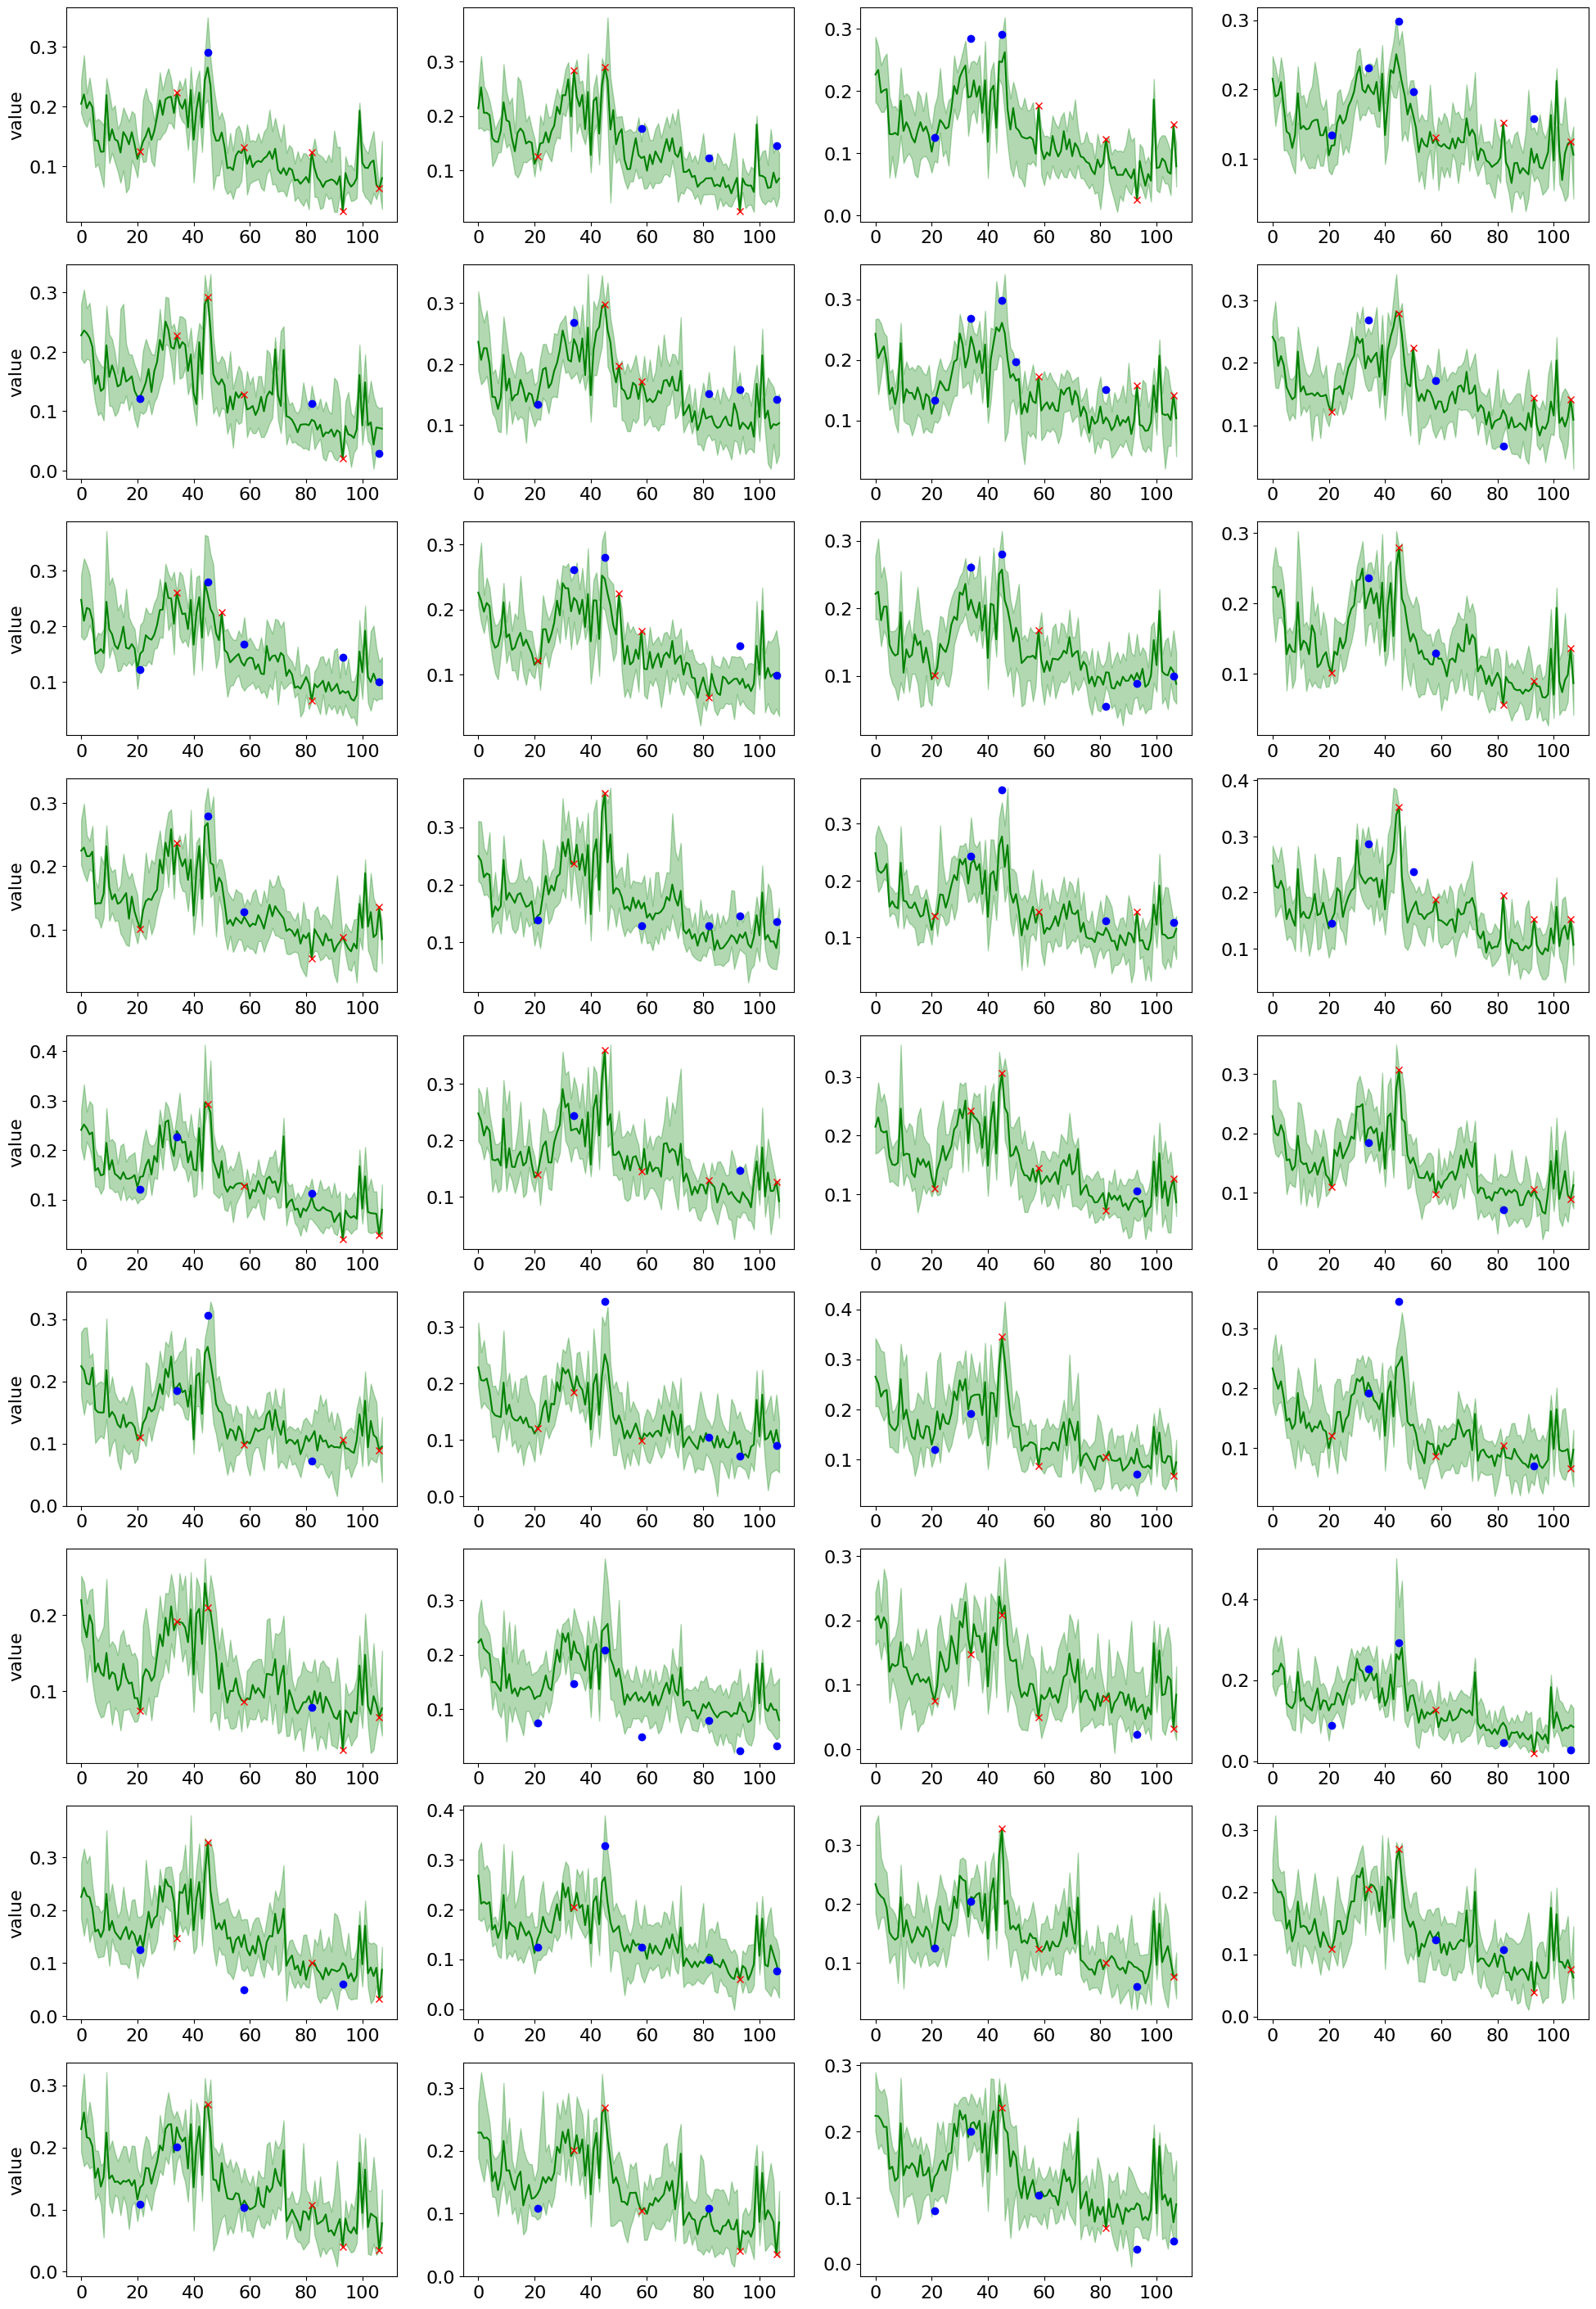

In [19]:
###airquality###
dataind = 50 #change to visualize a different sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])
offset = 0

for k in range(36):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k+offset], "y":all_evalpoint_np[dataind,:,k+offset]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k+offset], "y":all_given_np[dataind,:,k+offset]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k+offset], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k+offset],quantiles_imp[4][dataind,:,k+offset],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')


# Convert to original soil moisture sequence

In [20]:
def help(x, t_split, k_split):
    """
    :param x:
    :param t_split:
    :param k_split:
    :return:
    """
    batch_size = int(x.shape[0] / t_split / k_split)
    L = x.shape[1] * t_split
    K = x.shape[2] * k_split

    temp = x.reshape(batch_size, t_split, k_split, x.shape[1], x.shape[2])
    temp = temp.transpose(0, 1, 3, 2, 4).reshape(batch_size, L, K)


    # temp = np.vsplit(x, t_split)
    # temp = np.stack(temp, axis=0)
    # temp = np.vsplit(temp, int(B / t_split))
    # temp = np.stack(temp, axis=0)
    # temp = temp.transpose(0, 1, 3, 2, 4).reshape(-1, T*t_split, )
    return temp

In [21]:
t_split = 6
k_split = 36

all_target_np = help(all_target_np, t_split, k_split)
all_evalpoint_np = help(all_evalpoint_np, t_split, k_split)
all_observed_np = help(all_observed_np, t_split, k_split)
all_given_np = help(all_given_np, t_split, k_split)
new_quantiles_imp = []
for i in quantiles_imp:
    temp = help(i, t_split, k_split)
    new_quantiles_imp.append(temp)
quantiles_imp = new_quantiles_imp

In [22]:
L = all_target_np.shape[1]
K = all_target_np.shape[2]

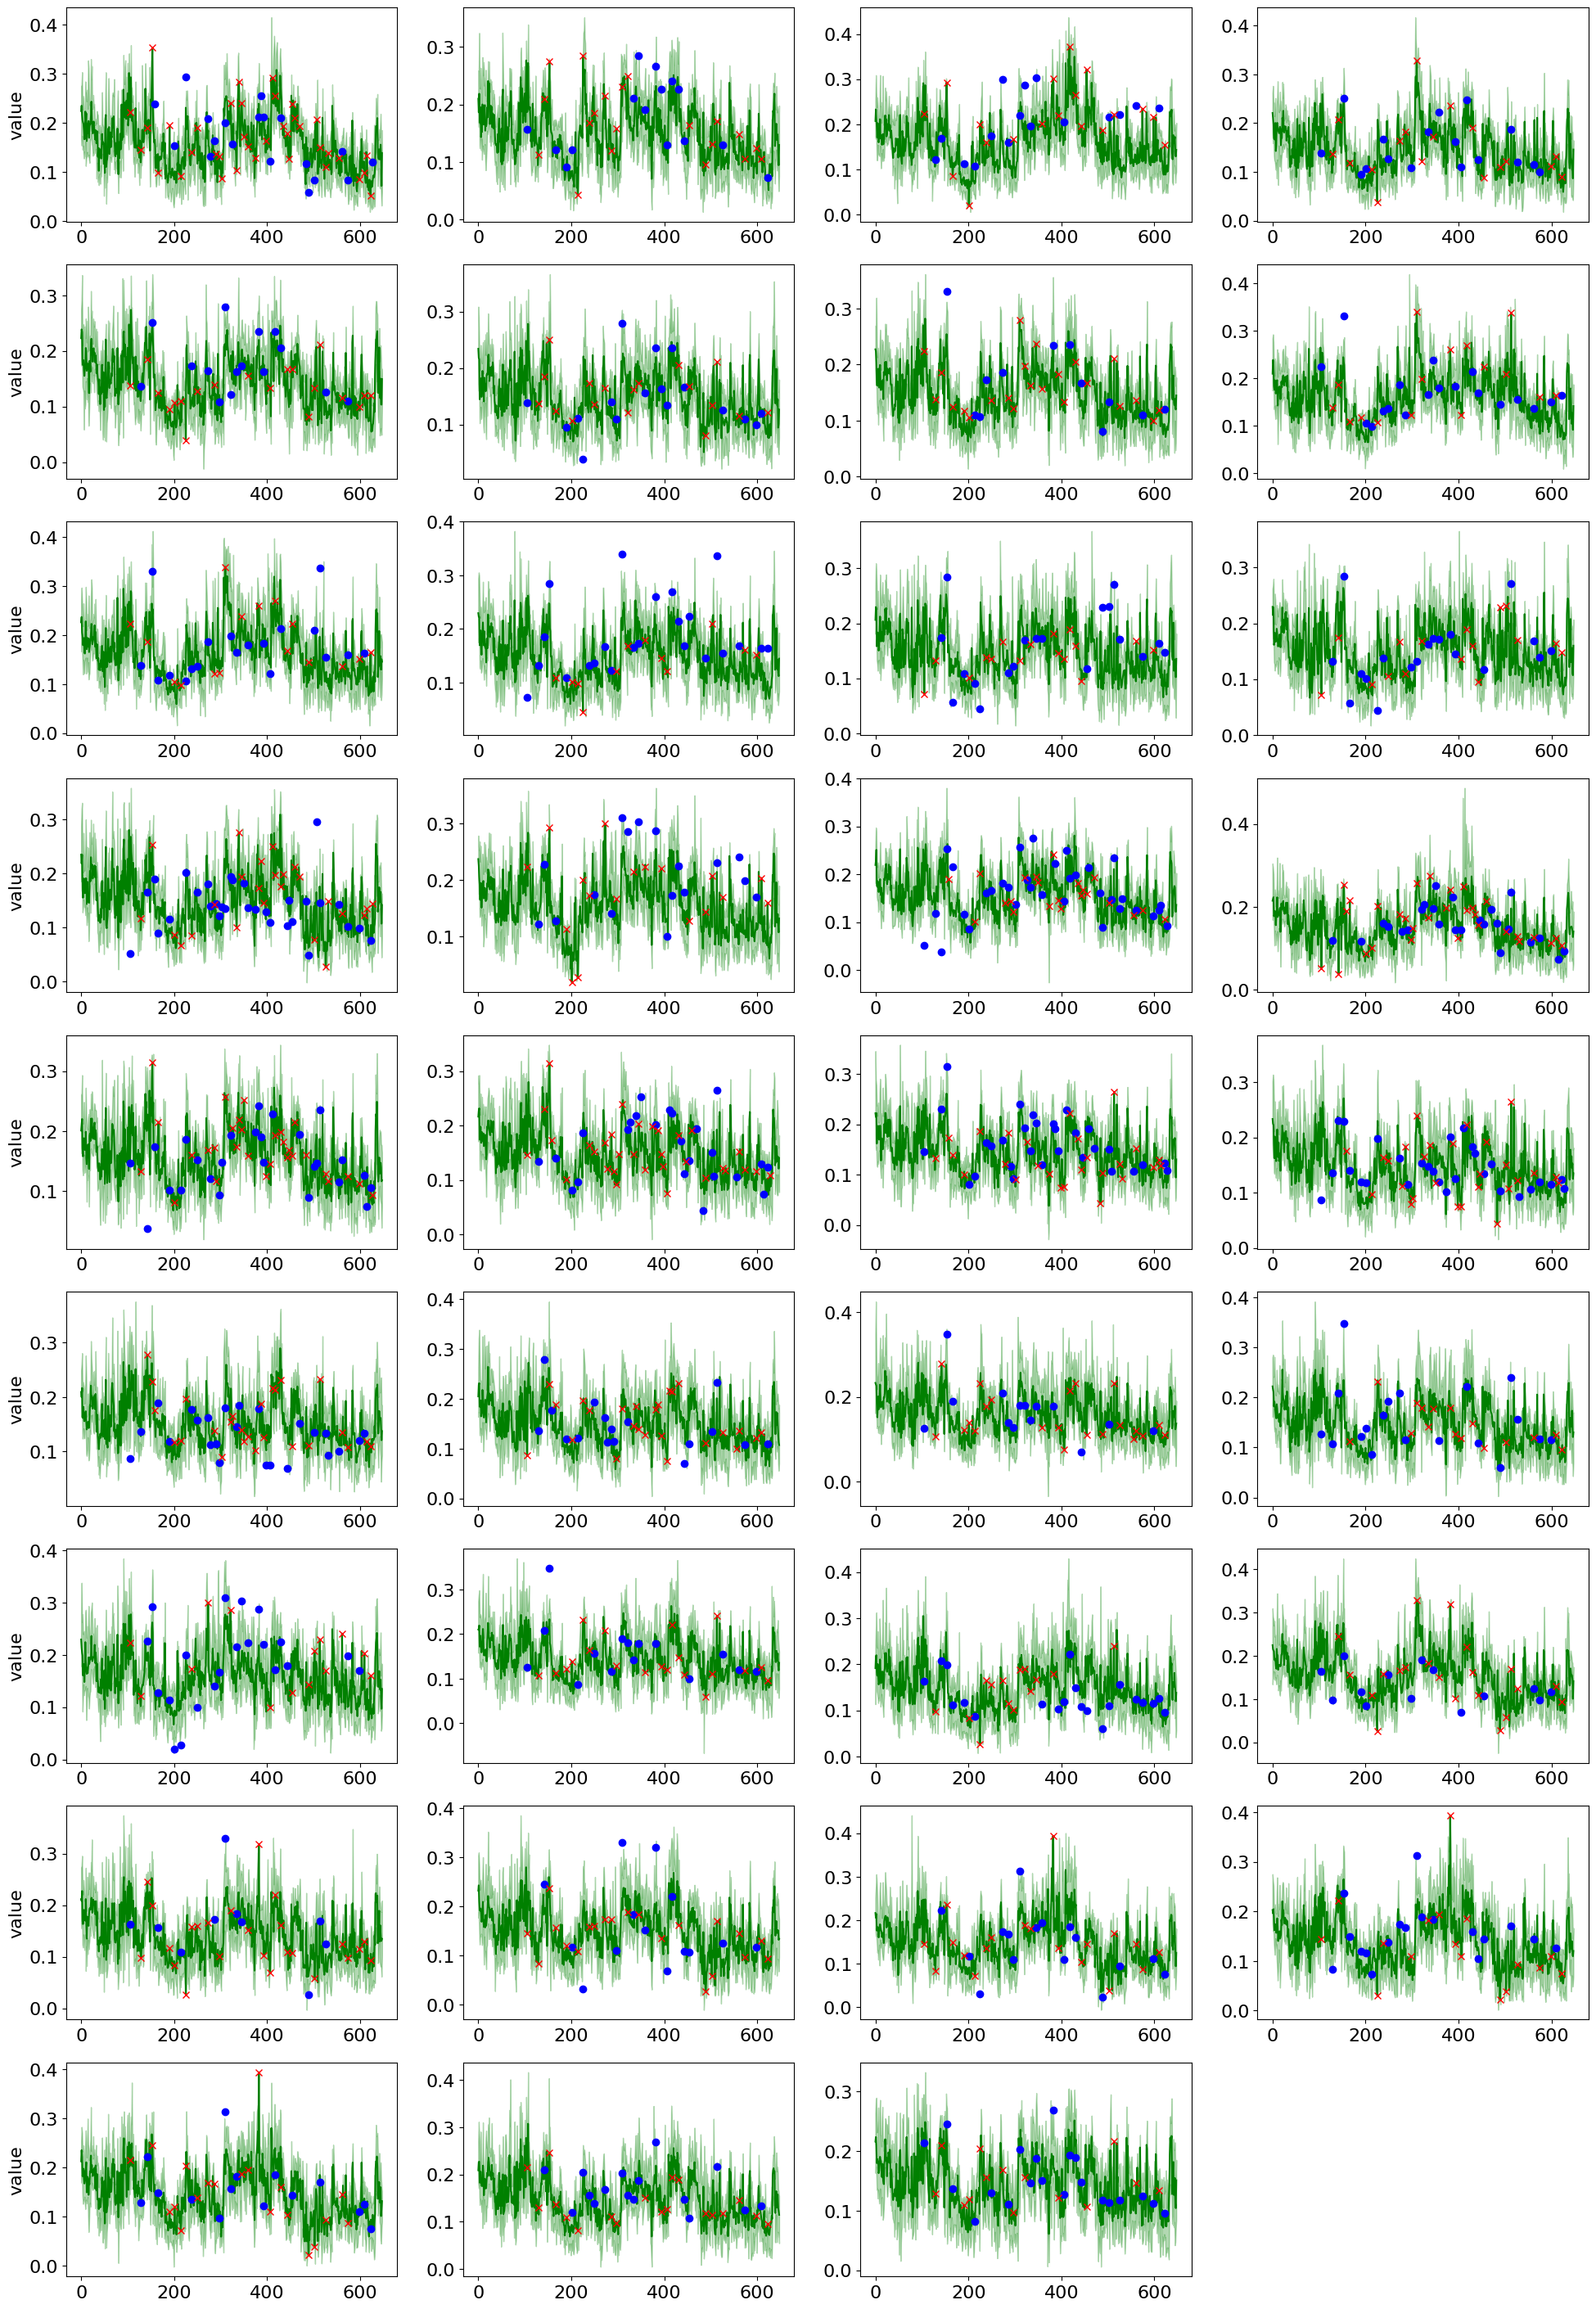

In [25]:
###airquality###
dataind = 0 #change to visualize a different sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])
offset = 0

for k in range(36):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k+offset], "y":all_evalpoint_np[dataind,:,k+offset]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k+offset], "y":all_given_np[dataind,:,k+offset]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k+offset], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k+offset],quantiles_imp[4][dataind,:,k+offset],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')
